In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import nltk

In [3]:
yelp_train_businesses = pd.read_csv("yelp_csv_dataset/yelp_train_businesses.csv")
yelp_train_tips = pd.read_csv("yelp_csv_dataset/yelp_train_tips.csv")
yelp_train_users = pd.read_csv("yelp_csv_dataset/yelp_train_users.csv")
yelp_train_checkins = pd.read_csv("yelp_csv_dataset/yelp_train_checkins.csv")
yelp_train_reviews = pd.read_csv("yelp_csv_dataset/yelp_train_reviews.csv")

yelp_test_businesses = pd.read_csv('yelp_csv_dataset/yelp_test_businesses.csv')
yelp_validate_businesses = pd.read_csv('yelp_csv_dataset/yelp_validate_businesses.csv')

In [4]:
train_df = yelp_train_businesses[['postal_code', 'stars', 'attributes', 'categories', 'hours']]
train_df = train_df[train_df['categories'].str.contains('restaurant', case=False, na=False)]
train_df.dropna(inplace=True)

train_df_sample = train_df.sample(n=10000, random_state=42)

train_x = train_df_sample[['postal_code', 'attributes', 'categories', 'hours']]
train_y = train_df_sample['stars']

In [5]:
validate_df = yelp_validate_businesses[['postal_code', 'stars', 'attributes', 'categories', 'hours']]
validate_df = validate_df[validate_df['categories'].str.contains('restaurant', case=False, na=False)]
validate_df.dropna(inplace=True)

validate_df_sample = validate_df.sample(n=10000, random_state=42)

val_x = validate_df_sample[['postal_code', 'attributes', 'categories', 'hours']]
val_y = validate_df_sample['stars']

In [6]:
test_df = yelp_test_businesses[['postal_code', 'stars', 'attributes', 'categories', 'hours']]
test_df = test_df[test_df['categories'].str.contains('restaurant', case=False, na=False)]
test_df.dropna(inplace=True)


test_x = test_df[['postal_code', 'attributes', 'categories', 'hours']]
test_y = test_df['stars']

In [8]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack, csr_matrix

encoder_x = OneHotEncoder(handle_unknown='ignore')
encoder_x.fit(train_x)
x_train_sparse = encoder_x.transform(train_x)
x_val_sparse = encoder_x.transform(val_x)
x_test_sparse = encoder_x.transform(test_x)

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train_sparse, train_y)

LinearRegression()

In [ ]:

val_accuracy = lr.score(x_val_sparse, val_y)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: -1.8721115182443162


In [10]:
from sklearn.metrics import mean_squared_error
predictions = lr.predict(x_test_sparse)

mse = mean_squared_error(test_y, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.5223689993367954


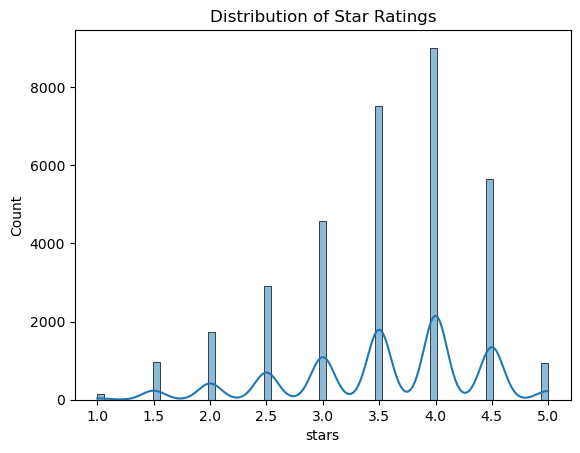

In [11]:
# Histogram for distribution of stars
sns.histplot(train_df['stars'], kde=True)
plt.title("Distribution of Star Ratings")
plt.show()

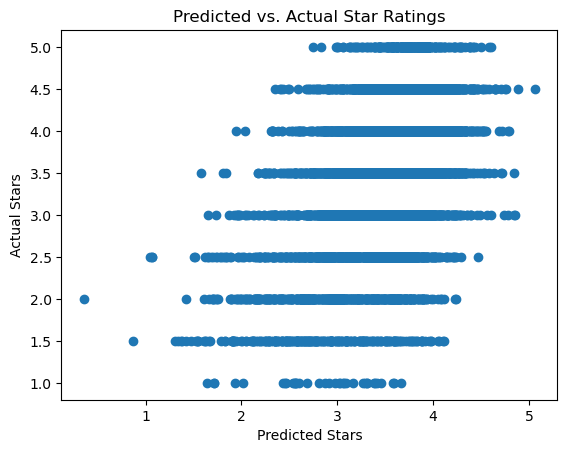

In [14]:
# Scatter plot of predicted vs. actual stars
plt.scatter(predictions, test_y)
plt.xlabel("Predicted Stars")
plt.ylabel("Actual Stars")
plt.title("Predicted vs. Actual Star Ratings")
plt.show()

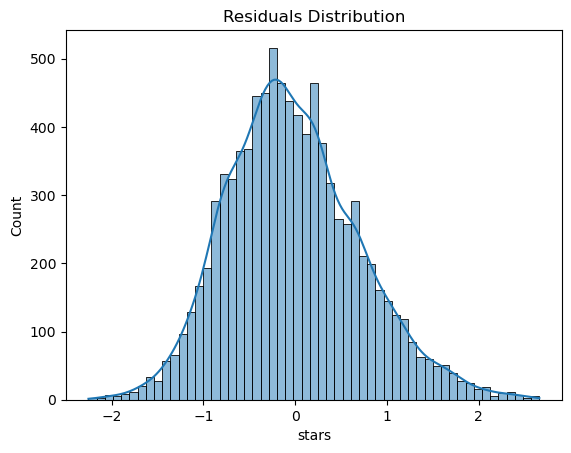

In [15]:
# Residual plot
residuals = predictions - test_y
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()

In [18]:
# Get the top 5 postal codes by frequency
top_postal_codes = train_df['postal_code'].value_counts().head(5)

print("Top 5 Postal Codes:")
print(top_postal_codes)

Top 5 Postal Codes:
70130    377
19107    373
19147    356
19103    292
37203    292
Name: postal_code, dtype: int64


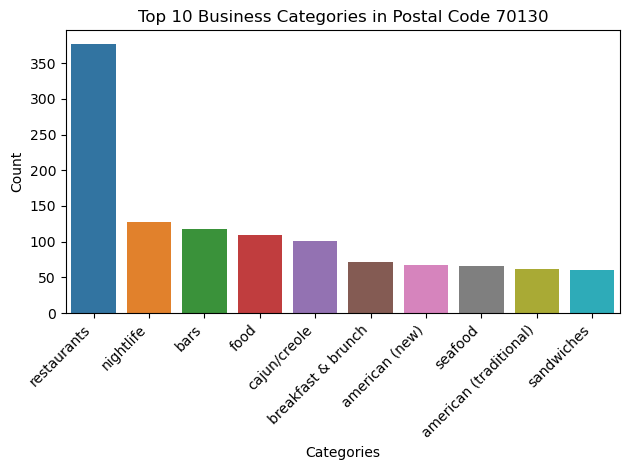

In [21]:
# Filter the dataset for postal code 70130
postal_70130_df = train_df[train_df['postal_code'] == '70130']

# Split the 'categories' column into individual categories
# Convert to lowercase for consistency
all_categories = postal_70130_df['categories'].str.split(', ').explode().str.lower()

# Get the frequency count of each category
category_counts = all_categories.value_counts()

# Extract the top 10 categories
top_10_categories = category_counts.head(10)

# Create a bar plot for the top 10 categories
sns.barplot(x=top_10_categories.index, y=top_10_categories.values)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Top 10 Business Categories in Postal Code 70130")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [42]:
bars_70130_df = postal_70130_df[postal_70130_df['categories'].str.contains('bar', case=False)]

bars_descending = bars_70130_df.sort_values(by='stars', ascending=False)

# Get top 10 bars (based on rating)
top_10_bars = bars_descending.head(10)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', -1)  # Show complete content of each column
top_10_bars


/var/folders/4n/n0c_y8b12q1ff4j6yh8p9gb40000gn/T/ipykernel_40250/1424543701.py:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)  # Show complete content of each column


,postal_code,stars,attributes,categories,hours,total_hours
1585,70130,5.0,"{'Ambience': ""{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': False}"", 'Corkage': 'True', 'RestaurantsTableService': 'True', 'BYOB': 'True', 'Caters': 'False', 'BikeParking': 'True', 'HappyHour': 'True', 'RestaurantsGoodForGroups': 'True', 'RestaurantsTakeOut': 'True', 'OutdoorSeating': 'False', 'BestNights': ""{'monday': False, 'tuesday': False, 'friday': False, 'wednesday': False, 'thursday': False, 'sunday': False, 'saturday': False}"", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsDelivery': 'False', 'Alcohol': ""u'full_bar'"", 'WheelchairAccessible': 'True', 'RestaurantsAttire': ""u'casual'"", 'HasTV': 'False', 'BusinessParking': ""{'garage': None, 'street': True, 'validated': None, 'lot': None, 'valet': False}"", 'RestaurantsPriceRange2': '2', 'GoodForMeal': ""{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}""}","Nightlife, Sandwiches, Bars, Mediterranean, Restaurants, Greek, Cocktail Bars","{'Monday': '0:0-0:0', 'Tuesday': '7:0-14:0', 'Thursday': '7:0-14:0', 'Friday': '17:0-21:0', 'Saturday': '17:0-21:0'}",22.0
37079,70130,5.0,"{'RestaurantsTakeOut': 'True', 'Caters': 'True', 'BusinessParking': ""{'garage': True, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'WiFi': ""u'free'"", 'WheelchairAccessible': 'True', 'Alcohol': ""u'none'"", 'RestaurantsDelivery': 'True', 'BusinessAcceptsCreditCards': 'True', 'BikeParking': 'True', 'RestaurantsReservations': 'False'}","Vegan, Acai Bowls, Coffee & Tea, Juice Bars & Smoothies, Food, Restaurants","{'Monday': '0:0-0:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-17:0', 'Saturday': '7:0-20:0', 'Sunday': '9:0-18:0'}",71.0
3947,70130,5.0,"{'WheelchairAccessible': 'True', 'BusinessAcceptsBitcoin': 'False', 'BusinessAcceptsCreditCards': 'True', 'Alcohol': ""u'none'"", 'HappyHour': 'False', 'RestaurantsTakeOut': 'True', 'OutdoorSeating': 'True', 'WiFi': ""u'free'"", 'BikeParking': 'True', 'RestaurantsDelivery': 'True', 'Caters': 'True', 'DogsAllowed': 'True', 'BusinessParking': ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'RestaurantsTableService': 'False', 'BYOB': 'False', 'HasTV': 'False', 'RestaurantsReservations': 'False'}","Juice Bars & Smoothies, Food, Restaurants, Coffee & Tea, Food Delivery Services, Vegan, Salad","{'Monday': '0:0-0:0', 'Tuesday': '7:0-17:0', 'Wednesday': '7:0-17:0', 'Thursday': '7:0-15:0', 'Friday': '7:0-17:0', 'Saturday': '9:0-17:0', 'Sunday': '9:0-17:0'}",54.0
5938,70130,5.0,"{'Caters': 'True', 'Alcohol': ""u'full_bar'"", 'BusinessParking': ""{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}"", 'RestaurantsReservations': 'False', 'RestaurantsTableService': 'True', 'HappyHour': 'True', 'Ambience': ""{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': False}"", 'GoodForMeal': ""{u'breakfast': None, u'brunch': None, u'lunch': None, u'dinner': True, u'latenight': None, u'dessert': None}"", 'Smoking': ""u'no'"", 'WheelchairAccessible': 'True', 'RestaurantsTakeOut': 'True', 'HasTV': 'True', 'BikeParking': 'True', 'RestaurantsDelivery': 'False', 'OutdoorSeating': 'True', 'BusinessAcceptsCreditCards': 'True', 'WiFi': ""u'free'""}","Cocktail Bars, Nightlife, Bars, Breakfast & Brunch, Restaurants, American (New)","{'Monday': '15:0-21:0', 'Tuesday': '15:0-21:0', 'Wednesday': '15:0-21:0', 'Thursday': '15:0-21:0', 'Friday': '15:0-21:0', 'Saturday': '7:0-21:0', 'Sunday': '7:0-21:0'}",58.0
64873,70130,4.5,"{'RestaurantsReservations': 'False', 'BusinessAcceptsCreditCards': 'True', 'Alcohol': ""'full_bar'"", 'OutdoorSeating': 'True', 'GoodForMeal': ""{'dessert': False, 'latenight': False, 'lunch

In [43]:
# Get worst 10 bars (based on rating)
worst_10_bars = bars_descending.tail(10)
worst_10_bars

,postal_code,stars,attributes,categories,hours,total_hours
58964,70130,3.0,"{'BikeParking': 'True', 'OutdoorSeating': 'False', 'GoodForKids': 'False', 'Music': ""{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}"", 'RestaurantsGoodForGroups': 'True', 'RestaurantsTakeOut': 'True', 'RestaurantsReservations': 'False', 'BusinessAcceptsCreditCards': 'True', 'HappyHour': 'True', 'Caters': 'False', 'RestaurantsPriceRange2': '2', 'Ambience': ""{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': True, 'upscale': False, 'classy': False, 'casual': True}"", 'WiFi': ""'free'"", 'CoatCheck': 'False', 'GoodForMeal': ""{'dessert': False, 'latenight': True, 'lunch': True, 'dinner': False, 'brunch': False, 'breakfast': False}"", 'HasTV': 'True', 'BusinessParking': ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'Alcohol': ""'full_bar'"", 'RestaurantsTableService': 'True', 'GoodForDancing': 'False', 'Smoking': ""u'no'"", 'RestaurantsDelivery': 'False', 'NoiseLevel': ""'average'"", 'RestaurantsAttire': ""'casual'"", 'BestNights': ""{'monday': True, 'tuesday': False, 'friday': False, 'wednesday': True, 'thursday': False, 'sunday': True, 'saturday': False}""}","Pubs, Bars, Restaurants, American (Traditional), Nightlife","{'Monday': '12:0-0:0', 'Tuesday': '12:0-0:0', 'Wednesday': '12:0-0:0', 'Thursday': '12:0-0:0', 'Friday': '11:0-2:0', 'Saturday': '11:0-2:0', 'Sunday': '11:0-0:0'}",91.0
23765,70130,3.0,"{'BikeParking': 'True', 'BusinessParking': ""{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}"", 'Caters': 'True', 'RestaurantsPriceRange2': '2', 'WiFi': ""u'no'"", 'GoodForKids': 'True', 'Alcohol': ""u'full_bar'"", 'NoiseLevel': ""u'average'"", 'RestaurantsDelivery': 'False', 'OutdoorSeating': 'False', 'HasTV': 'True', 'RestaurantsAttire': ""u'casual'"", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsTakeOut': 'True', 'RestaurantsGoodForGroups': 'True', 'RestaurantsReservations': 'False', 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"", 'HappyHour': 'True'}","Beer, Wine & Spirits, Bars, Nightlife, Burgers, Food, Restaurants","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', 'Wednesday': '7:0-22:0', 'Thursday': '7:0-22:0', 'Friday': '7:0-22:0', 'Saturday': '7:0-22:0', 'Sunday': '7:0-22:0'}",105.0
15930,70130,3.0,"{'BusinessParking': ""{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}"", 'NoiseLevel': ""'average'"", 'GoodForMeal': ""{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}"", 'GoodForDancing': 'False', 'Alcohol': ""u'full_bar'"", 'RestaurantsTableService': 'False', 'RestaurantsPriceRange2': '1', 'BikeParking': 'True', 'RestaurantsReservations': 'False', 'Smoking': ""u'outdoor'"", 'CoatCheck': 'False', 'RestaurantsTakeOut': 'True', 'GoodForKids': 'True', 'BusinessAcceptsCreditCards': 'True', 'RestaurantsDelivery': 'False', 'Music': '{}', 'RestaurantsGoodForGroups': 'True', 'WiFi': ""'no'"", 'HasTV': 'True', 'RestaurantsAttire': ""'casual'"", 'Ambience': ""{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': True, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}"", 'OutdoorSeating': 'False', 'HappyHour': 'True'}","Mexican, Nightlife, Restaurants, Bars, Cocktail Bars","{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', 'Wednesday': '11:0-0:0', 'Thursday': '11:0-2:0', 'Friday': '11:0-2:0', 'Saturday': '11:0-2:0', 'Sunday': '11:0-0:0'}",97.0
62763,70130,3.0,"{'BusinessAcceptsCreditCards': 'True', 'WiFi': ""u'free'"", 'HasTV': 'True', 'OutdoorSeating': 'True', 'NoiseLevel': ""u'average'"", 'GoodForKids': 'True', 'Caters': 'False', 'RestaurantsTakeOut': 'True', 'Alcohol': ""u'full_bar'

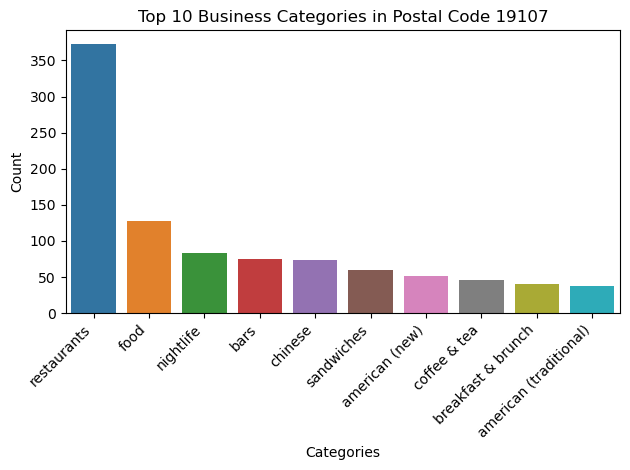

In [22]:
# Filter the dataset for postal code 19107
postal_19107_df = train_df[train_df['postal_code'] == '19107']

# Split the 'categories' column into individual categories
# Convert to lowercase for consistency
all_categories = postal_19107_df['categories'].str.split(', ').explode().str.lower()

# Get the frequency count of each category
category_counts = all_categories.value_counts()

# Extract the top 10 categories
top_10_categories = category_counts.head(10)

# Create a bar plot for the top 10 categories
sns.barplot(x=top_10_categories.index, y=top_10_categories.values)
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Top 10 Business Categories in Postal Code 19107")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [59]:
# Create a DataFrame with the same columns used in training
custom_data = {
    'postal_code': ['70130'],
    'attributes': ['''{'RestaurantsPriceRange2': '2', 'HasTV': 'True', 'Alcohol': "u'full_bar'", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsDelivery': 'False', 'NoiseLevel': "u'loud'", 'OutdoorSeating': 'False', 'RestaurantsAttire': "'casual'", 'GoodForKids': 'False', 'RestaurantsReservations': 'False', 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}", 'BikeParking': 'False', 'Smoking': "u'outdoor'", 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", 'RestaurantsGoodForGroups': 'True', 'WiFi': "'no'", 'RestaurantsTakeOut': 'True', 'BusinessAcceptsBitcoin': 'False', 'BusinessParking': 'None', 'Music': "{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}"}'''],
    'categories': ['Event Planning & Services, American (Traditional), Restaurants, Nightlife, Bars, Venues & Event Spaces, Sports Bars'],
    'hours': ['''{'Monday': '6:0-0:0', 'Tuesday': '6:0-0:0', 'Wednesday': '6:0-0:0', 'Thursday': '6:0-0:0', 'Friday': '6:0-0:0', 'Saturday': '6:0-0:0', 'Sunday': '6:0-0:0'}''']
}


input_df = pd.DataFrame(custom_data)


input_df_encoded = encoder_x.transform(input_df)


# Make a prediction with the encoded input data
prediction = lr.predict(input_df_encoded)

print("Predicted Star Rating:", prediction)

Predicted Star Rating: [3.03921185]


In [65]:
custom_data2 = {
    'postal_code': ['70130'],
    'attributes': ['''{'WheelchairAccessible': 'True','BikeParking': 'True','RestaurantsPriceRange2': '2', 'HasTV': 'True', 'Alcohol': "u'full_bar'", 'BusinessAcceptsCreditCards': 'True', 'RestaurantsDelivery': 'False', 'NoiseLevel': "u'loud'", 'OutdoorSeating': 'False', 'RestaurantsAttire': "'casual'", 'GoodForKids': 'False', 'RestaurantsReservations': 'False', 'Ambience': "{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}", 'BikeParking': 'False', 'Smoking': "u'outdoor'", 'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}", 'RestaurantsGoodForGroups': 'True', 'WiFi': "'no'", 'RestaurantsTakeOut': 'True', 'BusinessAcceptsBitcoin': 'False', 'BusinessParking': 'None', 'Music': "{'dj': False, 'background_music': False, 'no_music': False, 'jukebox': False, 'live': False, 'video': False, 'karaoke': False}"}'''],
    'categories': ['Event Planning & Services, American (Traditional), Restaurants, Nightlife, Bars, Venues & Event Spaces, Sports Bars'],
    'hours': ['''{'Monday': '0:0-0:0', 'Tuesday': '7:0-20:0', 'Wednesday': '7:0-20:0', 'Thursday': '7:0-20:0', 'Friday': '7:0-17:0', 'Saturday': '7:0-20:0', 'Sunday': '9:0-18:0'}''']
}


input_df2 = pd.DataFrame(custom_data2)


input_df_encoded2 = encoder_x.transform(input_df2)


# Make a prediction with the encoded input data
prediction2 = lr.predict(input_df_encoded2)

print("Predicted Star Rating:", prediction2)

Predicted Star Rating: [3.89090205]
